# Map Analysis II

###  Renée Hložek and Jeff McMahon

## Using our tools on real data

In this self study exercise, we are now going to use some public data from the ACT collaboration, compute power spectra and compare them to theory power spectra.

In [93]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
%cd /Users/eshaw/box/UTAustin_CMBSummerSchool/CMB-S4_AnalysisSummerSchool/
%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cds.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

C:\Users\eshaw\box\UTAustin_CMBSummerSchool\CMB-S4_AnalysisSummerSchool


# Reading in data and making simulated maps
Let's start by reading in a map and computing the power spectrum of the map, and then comparing to a theory map of a similar size/shape

0.49491833030853 0.49407681818181814
map mean: -3.5245380283448906 map rms: 311.228361194383


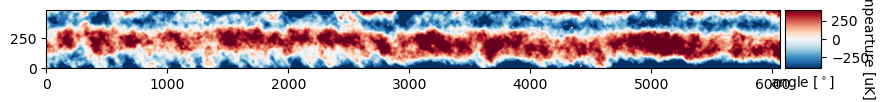

In [5]:
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map,c_min,c_max,Nx,Ny)


You can see that these ACT maps are long stripes, so we will cut a square patch out of the long strip and compute the PS on that patch.

In [3]:
print(Nx, Ny)

6061 484


map mean: 20.125159755016572 map rms: 124.47878213360549


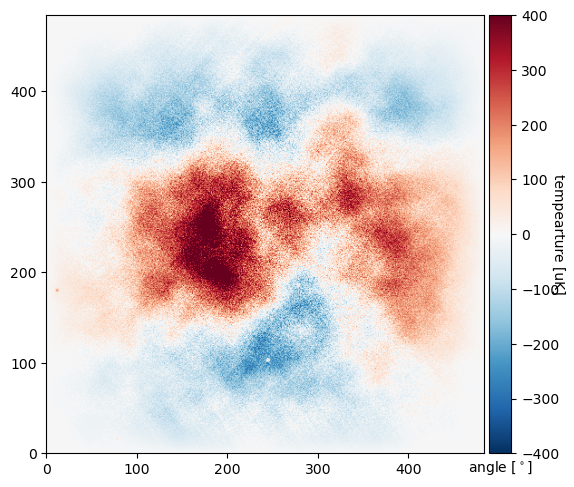

In [3]:
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size 
#Remember dimensions of these map are expressed (y,x) 


# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch
p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsizex=6,figsizey=6)


### We can see that there is a lot of power on large scales from the atmosphere. What do we expect to see in the power spectrum?
Let's make a theory map as we have in many other modules:

Number of sources required:  5000
map mean: -21.517199710606302 map rms: 46.55770978085153


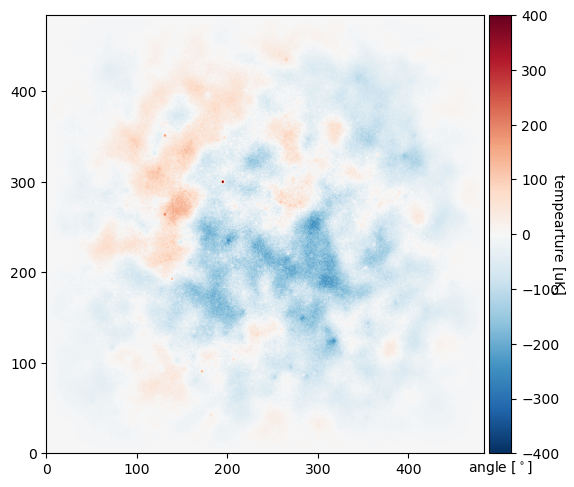

In [10]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorporate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N,figsizex=6,figsizey=6)

## We will now take the power spectrum of this apodised map, and the theory version

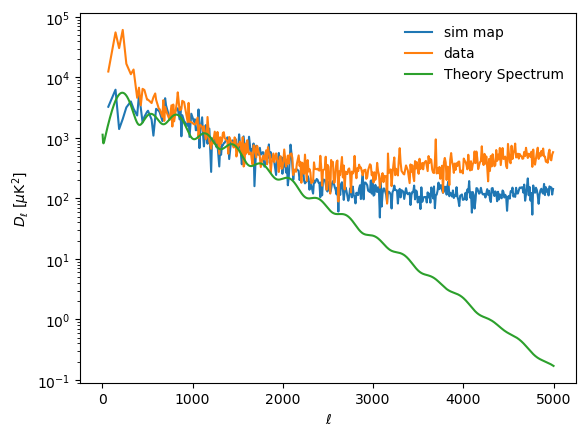

In [12]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='sim map')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()

plt.semilogy(ell,DlTT, label = 'Theory Spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
leg = plt.legend()
leg.draw_frame(False)
plt.show()

Notice that the power spectrum is biased high on large scales - as we expected it to be.
How might you remove that large scale power before computing the power spectrum?

<font color='red'>EXCERCISE: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for ell_min. Also, can you think about how to remove the ringing the power on small scales? Discuss the shape of the apodising window and the large scale power leaking to small scales.

## Your code and plots here

???

<font color='red'>EXCERCISE: </font>  We cut out a particular patch from the ACT strip. Cut out different patches and view them. By using the power spectrum code in the modules file, compute both the auto and the cross spectra for this map. Discuss how you would estimate the error bars on this power spectrum, by comparing the auto with the cross power spectra.

HINT from Workbook 4: 
### Calibrating the noise bias

The noise bias can be computed by running noise only simulations through the naive power spectrum estimator and computing the average power spectrum.

NOTE: An alternative approach exists for dealing with the noise.  If you can subdivide your data into subsets with common signal but independent noise, one can compute "cross-spectra" between these subsets.  (You compute these by doing a 2d FFT on each subset and then multiplying one by the complex conjugate of the other.)   This results in some information loss (since you are throwing out the auto-correlation of each subset, but it completely eliminates potential measurement bias from an incorrect noise model.  

As a two part exercise: (1) use the wrong noise model in analyzing the power spectrum to see what happens, and (2) implement a cross-spectrum estimator to see that this noise bias goes away with cross spectra.  Also note that the error bars grow with the cross spectrum. 

In [80]:
# Your code here

## Q: How many auto_spectra can we make? How many unique cross spectra?

In [ ]:
window = (cosine_window(N))
N=int(Ny) # take only one dimension

print(f'Breaking long strip map into {Nx//Ny} smaller maps')
skypatch_data = {}
for patch in range(Nx//Ny):
    patchmap = map[0:int(N), (patch)*int(N):(patch+1)*int(N)]
    appodized_map = window * patchmap
    patchspectrum = calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)
    skypatch_data[patch]= {'appmap': appodized_map,
                           'spectrum': patchspectrum} 
    #p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsizex=6, figsizey=6)

In [62]:
patch_autospectra = np.array([skypatch_data[patch]['spectrum'][1] for patch in skypatch_data.keys()])


Text(0.5, 1.0, 'auto-spectra of all patches')

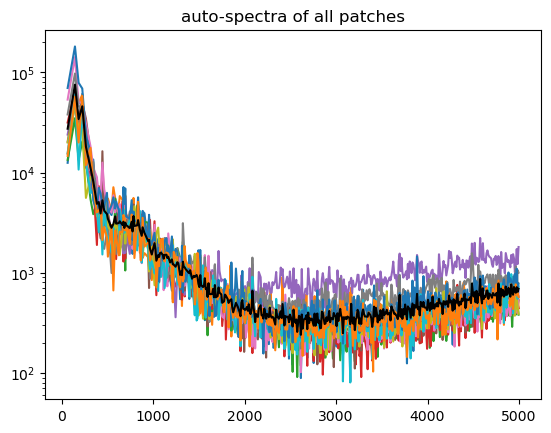

In [69]:
ells = skypatch_data[0]['spectrum'][0]
plt.figure()
for key in skypatch_data.keys():
    plt.semilogy(ells, skypatch_data[key]['spectrum'][1]*(ells*(ells+1))/2./np.pi)
plt.semilogy(ells, np.nanmean(patch_autospectra, axis=0)*(ells*(ells+1))/2./np.pi,'k', label='avg')

plt.title('auto-spectra of all patches')

In [51]:
from math import comb
crosses = comb(Nx//Ny, 2)
print(crosses)

66


In [78]:
cross_spec = []
for i in skypatch_data.keys():
    for j in skypatch_data.keys():
        if i < j:
            _,Cls = calculate_2d_spectrum(skypatch_data[i]['appmap'],\
                                      delta_ell,ell_max,pix_size,N,\
                                      Map2=skypatch_data[j]['appmap'])
            cross_spec.append(Cls)

C:\Users\eshaw\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eshaw\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
len(cross_spec)

66

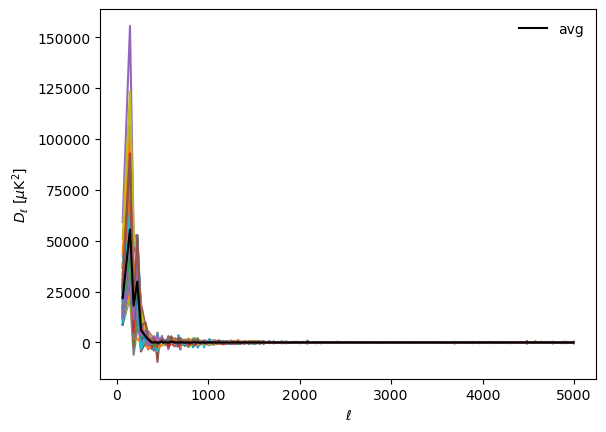

In [91]:
plt.figure()
for s in cross_spec:
    plt.plot(ells,s *ells*(ells+1)/2./np.pi)
plt.plot(ells, np.nanmean(cross_spec, axis=0)*ells*(ells+1)/2./np.pi,'k',label = 'avg')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)

plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')

plt.show()

In [95]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
#plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
#                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='sim map')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi \
                - np.nanmean(cross_spec, axis=0)*ells*(ells+1)/2./np.pi , label='data')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi \
                - np.nanmean(cross_spec, axis=0)*ells*(ells+1)/2./np.pi , label='data - mean cross spec')


#plt.clf()

plt.semilogy(ell,DlTT, label = 'Theory Spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
leg = plt.legend()
leg.draw_frame(False)
plt.show()

IndexError: index 511 is out of bounds for axis 0 with size 484

<font color='red'>EXCERCISE: </font>  Given the value of the PS shown here on small scales, we can estimate the noise level in the ACT maps for this season. Plot noise curves for a few values and show here, and do a simple "chi-by-eye" fit for the noise level.

# Your code here
????

Your discussion here

<font color='red'>EXCERCISE: </font>  Plot the 2D power spectrum, both of your input theory+ noise and the ACT data. What does that tell you about real-world noise from CMB Experiments?

In [ ]:
## Your code here

## Frequency dependence of maps and foregrounds

Now we are going to look at ACT maps on the same patch of the sky, but in a different frequency band.

0.49491833030853 0.49407681818181814
map mean: -35.148097186618045 map rms: 319.0813587167169


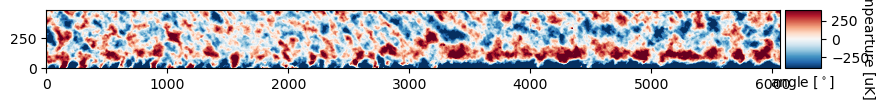

In [11]:
map220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map220,c_min,c_max,Nx,Ny)


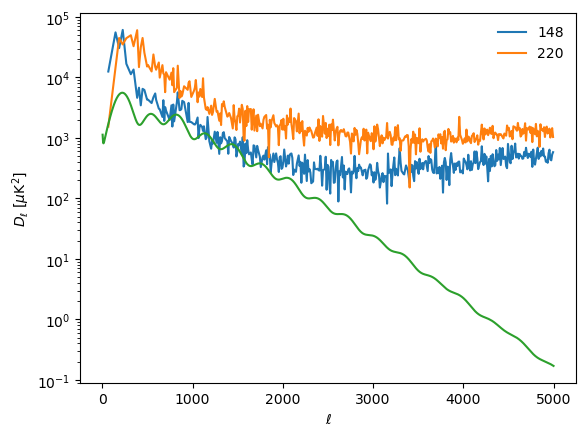

In [12]:
N=int(Ny) # take only one dimension
map_patch220 = map220[0:int(N), 0:int(N)] #trimming the map down to size
window = (cosine_window(N))
appodized_map220 = window * map_patch220

binned_ell_dat220, binned_spectrum_dat220 = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148')
plt.semilogy(binned_ell_dat220,binned_spectrum_dat220* binned_ell_dat220 * (binned_ell_dat220+1.)/2. / np.pi, label='220')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE: </font> The spectrum is biased high from point sources on all scales. Use the code from the previous notebook to determine the noise bias for this spectrum and remove it.

In [ ]:
## Your code here